In [1]:
import string
import random

import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# consts
DATASET_FILENAME = 'names.txt'
RANDOM_SEED = 42

# config
NGRAM_SIZE = 3
BATCH_SIZE = 128
EMBEDDING_DIM = 10
HIDDEN_LAYER_SIZE = 100

TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1

assert TRAIN_SIZE + VAL_SIZE + TEST_SIZE == 1

random.seed(RANDOM_SEED)

In [3]:
def read_names():
    with open(DATASET_FILENAME, 'r') as f:
        names = f.read()
    return names.split()

In [4]:
names = read_names()
letters = ['.'] + list(string.ascii_lowercase)
letter_to_idx = {letter: idx for idx, letter in enumerate(letters)}
idx_to_letter = {idx: letter for idx, letter in enumerate(letters)}

In [5]:
def build_dataset(names):
    dataset_x = []
    dataset_y = []
    for name in names:
        cur_context = '...'
        for cur_ans_char in name + '.':
            # print(f'{cur_context} -> {cur_ans_char}')
    
            cur_x = [letter_to_idx[letter] for letter in cur_context]
            cur_y = letter_to_idx[cur_ans_char]
    
            dataset_x.append(cur_x)
            dataset_y.append(cur_y)
            
            cur_context = cur_context[1:] + cur_ans_char
    return dataset_x, dataset_y


def split_dataset(names):
    random.shuffle(names)
    
    val_start_idx = int(len(names) * TRAIN_SIZE)
    test_start_idx = int(val_start_idx + len(names) * VAL_SIZE)
    
    names_train = names[:val_start_idx]
    names_val = names[val_start_idx:test_start_idx]
    names_test = names[test_start_idx:]
    
    dataset_train_x, dataset_train_y = build_dataset(names_train)
    dataset_val_x, dataset_val_y = build_dataset(names_val)
    dataset_test_x, dataset_test_y = build_dataset(names_test)
    return map(torch.tensor, (dataset_train_x, dataset_train_y, dataset_val_x, dataset_val_y, dataset_test_x, dataset_test_y))

In [6]:
dataset_train_x, dataset_train_y, dataset_val_x, dataset_val_y, dataset_test_x, dataset_test_y = split_dataset(names)

In [7]:
def get_batch():
    batch_idxs = torch.randint(0, len(dataset_train_x), (BATCH_SIZE,))
    x = dataset_train_x[batch_idxs]
    y = dataset_train_y[batch_idxs]
    return x, y

In [8]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(len(letter_to_idx), EMBEDDING_DIM)
        self.fc1 = nn.Linear(NGRAM_SIZE * EMBEDDING_DIM, HIDDEN_LAYER_SIZE)
        self.fc2 = nn.Linear(HIDDEN_LAYER_SIZE, len(letter_to_idx))
    
    def forward(self, x):
        # x: (BATBATCH_SIZE * NGRANGRAM_SIZE * EMBEDDING_LEN)
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = torch.tanh(x)

        x = self.fc2(x)
        return x

In [9]:
model = MLP()

In [10]:
iter_history = []
loss_history = []

In [16]:
def train(iters=10000):
    for iter_num in tqdm(range(iters)):
        x, y = get_batch()
        logits = model(x)
        loss = F.cross_entropy(logits, y)
    
        iter_history.append(iter_num)
        loss_history.append(loss.item())
    
        for p in model.parameters():
            p.grad = None
        loss.backward()
        
        lr = 0.01
        for p in model.parameters():
            p.data -= lr * p.grad

In [17]:
train()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 500.91it/s]


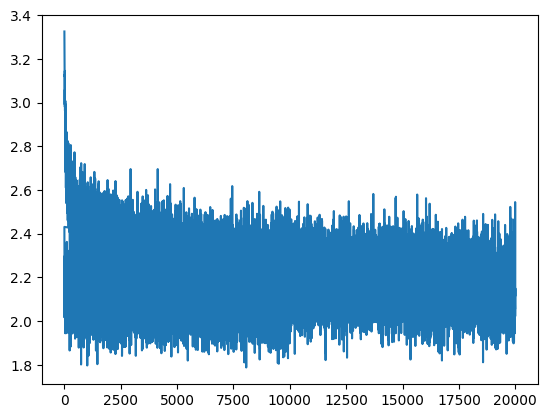

In [18]:
plt.plot(iter_history, loss_history)

In [14]:
def compute_val_loss():
    logits = model(dataset_val_x)
    loss = F.cross_entropy(logits, dataset_val_y)
    return loss

In [15]:
compute_val_loss()

tensor(2.1795, grad_fn=<NllLossBackward0>)

In [19]:
compute_val_loss()

tensor(2.1592, grad_fn=<NllLossBackward0>)

In [31]:
def generate_names(num=10):
    for _ in range(num):
        context = '...'
        name = []
        while True:
            x = torch.tensor([[letter_to_idx[c] for c in context]])
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            ans_chr_idx = torch.multinomial(probs, num_samples=1).item()
            ans_chr = idx_to_letter[ans_chr_idx]
            if ans_chr == '.':
                print(''.join(name))
                break
            name.append(ans_chr)
            context = context[1:] + ans_chr

In [34]:
generate_names()

dae
makiyamelynn
lee
aina
ref
lina
gize
kaylena
alet
darianek


# Debug / dev section

In [ ]:
for _x, _y in zip(x, y):
    context = []
    for idx in _x:
        context.append(idx_to_letter[idx.item()])
    print(f'{''.join(context)} -> {idx_to_letter[_y.item()]}')

In [99]:
e = nn.Embedding(len(letter_to_idx), EMBEDDING_DIM)

In [100]:
x = e(x)

In [101]:
x

tensor([[[-0.2065, -0.7045],
         [-0.2065, -0.7045],
         [-0.5793,  1.3076]],

        [[-0.3547,  0.0642],
         [-1.2751,  0.7274],
         [-0.3547,  0.0642]],

        [[-0.2065, -0.7045],
         [-0.2065, -0.7045],
         [-0.5793,  1.3076]],

        [[-0.2065, -0.7045],
         [-0.2065, -0.7045],
         [-0.6918, -0.4708]],

        [[-0.2065, -0.7045],
         [-0.2065, -0.7045],
         [-0.2065, -0.7045]]], grad_fn=<EmbeddingBackward0>)

In [102]:
x = x.view(BATCH_SIZE, -1)

In [103]:
x

tensor([[-0.2065, -0.7045, -0.2065, -0.7045, -0.5793,  1.3076],
        [-0.3547,  0.0642, -1.2751,  0.7274, -0.3547,  0.0642],
        [-0.2065, -0.7045, -0.2065, -0.7045, -0.5793,  1.3076],
        [-0.2065, -0.7045, -0.2065, -0.7045, -0.6918, -0.4708],
        [-0.2065, -0.7045, -0.2065, -0.7045, -0.2065, -0.7045]],
       grad_fn=<ViewBackward0>)

In [107]:
fc1 = nn.Linear(NGRAM_SIZE * EMBEDDING_DIM, HIDDEN_LAYER_SIZE)

In [108]:
x = fc1(x)

In [112]:
x = torch.tanh(x)

In [113]:
x.shape

torch.Size([5, 100])

In [114]:
fc2 = nn.Linear(HIDDEN_LAYER_SIZE, len(letter_to_idx))

In [115]:
x = fc2(x)

In [116]:
loss = F.cross_entropy(x, y)

In [117]:
loss

tensor(3.4442, grad_fn=<NllLossBackward0>)

In [147]:
x, y = get_batch()

In [225]:
logits = model(x)

In [226]:
loss = F.cross_entropy(logits, y)
loss

tensor(0.2481, grad_fn=<NllLossBackward0>)

In [227]:
for p in model.parameters():
    p.grad = None

In [228]:
loss.backward()

In [229]:
lr = 0.1
for p in model.parameters():
    p.data -= lr * p.grad